# Thinkful - Final Capstone: Siting Wind Farms (continued)
## Supervised Learning models

### Jeremy Brezovan


## Imports and functions

In [24]:
import time

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Patch

from shapely.geometry import Point
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon
from shapely.ops import nearest_points
from shapely.ops import unary_union

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [21]:
def turbine_color(turbine_class):
    if turbine_class == 0:
        return 'limegreen'
    elif turbine_class == 1:
        return 'gold'
    elif turbine_class == 2:
        return 'orangered'
    else:
# Blue dots on the map mean shenanigans occurred and we need to investigate
        return 'blue'

In [4]:
def show_feat_importance(model,df):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    df_cols = df.shape[1]
    
    for f in range(df_cols):
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f],
                                           df.columns[f],
                                           importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(df_cols),
            importances[indices],
            color="r",
            yerr=std[indices],
            align="center")
    plt.xticks(range(df_cols), indices)
    plt.xlim([-1, df_cols])
    plt.show()

In [215]:
# Plot of candidate sites and existing turbines
def plot_candidate_sites(candidates,turbines,power):
    fig = plt.figure()
    ax = lower48_borders.loc[lower48_borders['STUSPS'] == us_state].plot(color='whitesmoke',edgecolor='black')
    candidates.plot(ax=ax,color='blue',alpha=.4)
    ax.scatter(turbines['xlong'],turbines['ylat'],
                color=turbines['turbine_class'].apply(lambda x: turbine_color(x)),
                alpha=.5)
    power.plot(ax=ax,color='grey')
    plt.title('Candidate sites and existing turbines in {}'.format(us_state),
             fontweight='bold')
    plt.show()
    unique, counts = np.unique(turbines['turbine_class'],return_counts=True)
    plot_labels = pd.DataFrame(counts,columns=['count'],index=unique)
    label_dict = {}
    for i,j in zip(plot_labels.index,plot_labels['count']):
              label_dict[i] = j
    label_arr = ['{} - {}'.format(i,label_dict[i]) for i in label_dict]
    fig2, ax2 = plt.subplots(1,1,figsize=(2,2))
    ax2.axis('off')
    legend_handles = []
    for turbine_class in unique:
        legend_handles.append(Patch(facecolor=turbine_color(turbine_class), edgecolor='b',
                                              label='{} - {}'.format(turbine_class,label_dict[turbine_class])))
    legend1 = plt.legend(handles=legend_handles,
                        labels=label_arr,
                        loc="upper left", title="turbine_class - count",
                        title_fontsize=20,fontsize=16)
    plt.show()
    plt.close()

In [268]:
def score_distribution(df,column):
    cluster_pos_stats = df['build_here'].value_counts()
    classes = df['build_here'].unique()
    number_of_subplots = len(classes)
    xlabel_dict = {0: 'non-candidate sites',
                   1: 'model candidate sites'}

    fig, axes = plt.subplots(1, 2, sharey=True,figsize=(15,5))
    fig.suptitle('Comparison of features for non-candidate vs. candidate sites')
    for i,v in enumerate(classes):
        this_cluster_df = df.loc[df['build_here'] == v]
        ax1 = plt.subplot(1,number_of_subplots,v+1)

        sns.distplot(this_cluster_df[column],
                     ax=ax1,
                     label=v,
                     kde=False,
                     bins=30,
                     color=['green' if v == 1 else 'red'],
                     hist_kws={'log':True},
                    )

        this_mean = this_cluster_df[column].mean()
        this_median = this_cluster_df[column].median()
        this_stddev = this_cluster_df[column].describe()['std']

        ax1.axvline(this_median,color='black',dashes=(1,2))
        ax1.axvline(this_mean - this_stddev,color='green',dashes=(3,3))
        ax1.axvline(this_mean,color='green')
        ax1.axvline(this_mean + this_stddev,color='green',dashes=(3,3))

        plt.xlabel('{} - {}\nmedian = {}\nmean = {}\nstandard deviation = {}'\
                   .format(column,xlabel_dict[v],this_median,this_mean,this_stddev))
    
    plt.ylabel('count')
    plt.suptitle("Distribution of {}".format(column))
    plt.show()
    plt.close()

## Data: wrangled. Now, build something

[In the first notebook for this capstone](https://github.com/iamjeremybe/thinkful_data_science/blob/master/Final%20Capstone/Thinkful%20Final%20Capstone%20-%20Siting%20Wind%20Farms.ipynb), I introduced the datasets, generated a target feature using an unsupervised learning model, and detailed the use of some external scripts that generated additional features that can be used to train a supervised learning model.

In this notebook, we can run a supervised learning model, and analyze the candidate sites for new wind farms that the model suggests.

My original thought was to build two supervised learning models--one with a binary output, simply stating whether or not a cell from the NREL dataset would be a good site for a turbine. (A cell is approximately 1/3 of a square degree of latitude/longitude, or 23x23 miles / 37x37 km.)

The proposed second model would have been trained on the attributes of land where turbines currently exist. Input would be attributes of the cells from the NREL dataset that the first model suggested as candidate sites. Output would have been turbine_class, describing what kind of turbine would be best suited for a given site.

What I found in exploring the unsupservised model's output was that the turbine_classes were largely determined by project age and size. Turbine technology has improved over time, leading to projects with fewer turbines, but turbines that are larger and have a higher output capacity.

I feel that at best, we can still map the existing turbines along with the candidate sites proposed by the model.

In [196]:
disk_dir='/home/jeremy/Documents/Jupyter/Final Capstone'
us_state = 'KS'

In [197]:
lower48_borders = gpd.read_file('./lower48_borders.geojson',driver='GeoJSON')

In [198]:
nrel_state = gpd.read_file('{}/nrel_augmented_by_state/nrel_augmented_{}.geojson'.format(disk_dir,us_state),driver='GeoJSON')

### Data prep

Encode values for one of the features related to transmission lines, define a target variable, and split into training and test data.

In [199]:
vc_le = LabelEncoder()
nrel_state['volt_class_encoded'] = vc_le.fit_transform(nrel_state['VOLT_CLASS'])

In [231]:
nrel_state['VOLT_CLASS'].value_counts()

345        17884
220-287     6816
Name: VOLT_CLASS, dtype: int64

In [230]:
nrel_state['volt_class_encoded'].value_counts()

1    17884
0     6816
Name: volt_class_encoded, dtype: int64

The target variable for the supervised learning model is going to be a simple binary value, calculated based on whether or not turbines already exist in a location (a sure sign that it is a suitable location for wind turbines!), or whether the wind_class variable from NREL's dataset with exclusions is high enough.

In [200]:
nrel_state['target'] = np.where( (nrel_state['turbine_count'] > 0) | (nrel_state['wind_class_excl'] >= 3), 1, 0)

In [201]:
# Train/test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(nrel_state[['SHAPE__Len','VOLTAGE','volt_class_encoded',
                                                                'dist_to_nearest_line','line_count',
                                                                'wind_class','geometry']],
                                                        nrel_state['target'], 
                                                        test_size=0.33, 
                                                        random_state=42)

## SGD Classifier / single fit

The SGD classifier performed well enough training against a single dataset...but the random forest below outperformed the SGD classifier.

I had a thought to try incremental learning--to generate a full set of data for every state, and train a model using all of those datasets. Unfortunately, generating 48 states' worth of data turned out to be a major challenge in terms of processing time, power, and disk space.

Had I the resources to proceed with that plan, I would replace .fit() below with .partial_fit(), and feed in states' training datasets one by one. The 

In [202]:
sgdc = SGDClassifier()
sgdc.fit(X_train1.drop('geometry',axis='columns'),y_train1)#,classes=[0,1])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [203]:
# How does it do against our test dataset?
y_pred1_sgd = sgdc.predict(X_test1.drop('geometry',axis='columns'))
sgdc.score(X_test1.drop('geometry',axis='columns'),y_test1)

0.826278984173721

## Random Forest

The augmented NREL dataset doesn't have a lot of features, so I thought perhaps a random forest would be easy to train. As it turns out--yes! Depending on the state, the test set will score at or above 90% with no additional tuning. (Kansas' test dataset returns a score of 94%!)

In [204]:
# Train the model
rfc = RandomForestClassifier()
rfc.fit(X_train1.drop('geometry',axis='columns'),y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [205]:
# How does it do against our test dataset?
y_pred1 = rfc.predict(X_test1.drop('geometry',axis='columns'))
rfc.score(X_test1.drop('geometry',axis='columns'),y_test1)

0.9395166237271501

In [206]:
confusion_matrix(y_test1,y_pred1)

array([[ 450,  345],
       [ 148, 7208]])

### Random Forest feature importance 

Feature ranking:
1. feature 3: SHAPE__Len (0.447131)
2. feature 5: VOLTAGE (0.256343)
3. feature 0: volt_class_encoded (0.151817)
4. feature 4: dist_to_nearest_line (0.130297)
5. feature 1: line_count (0.008017)
6. feature 2: wind_class (0.006394)


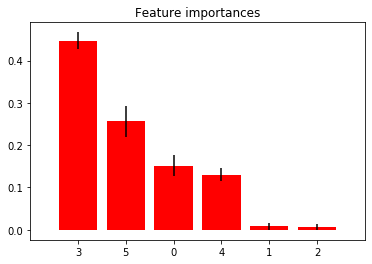

In [207]:
show_feat_importance(rfc,X_train1.drop('geometry',axis='columns'))

__It's interesting that the transmission line features are the most significant to the model.__

I mean, the only input to the model that isn't a transmission line attribute is NREL wind_class, but that feature represents so much information--both wind speed and suitable topography--that I thought it would be more significant. Instead, it is consistently dead last in the ranking, no matter which state's data is used.

In [208]:
X_test_out1 = X_test1.copy(deep=True)
X_test_out1 = gpd.GeoDataFrame(X_test_out1)
X_test_out1['build_here'] = y_pred1

In [209]:
X_test_out1.shape

(8151, 8)

In [214]:
turbines_state = gpd.read_file('./turbines_by_state/turbines_{}.geojson'.format(us_state),driver='GeoJSON')
power_state = gpd.read_file('./power_by_state/power_{}.geojson'.format(us_state),driver='GeoJSON')

## Putting it together - supervised learning model output + unsupervised learning model output

__In the plot below:__
* Candidate sites chosen by the supervised learning model are shaded blue;
* Transmission lines are drawn in grey;
* Turbines are colored according to the same color scheme assigned in the analysis of the unsupervised learning model.

__Together, these datasets give us a high-level picture of what currently exists, and where we can look next.__

<Figure size 432x288 with 0 Axes>

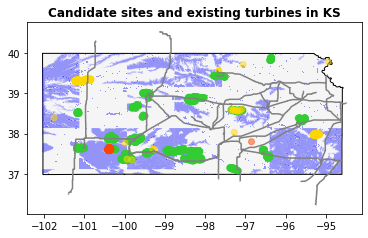

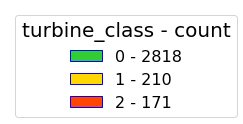

In [216]:
plot_candidate_sites(X_test_out1.loc[X_test_out1['build_here'] == 1],turbines_state,power_state)

## What differentiates good candidate sites from other sites?

We can look at the distributions for non-candidate sites vs. candidate sites, and check out the differences between their summary statistics (mean, median, standard deviation).

In [220]:
X_test_out1.loc[X_test_out1['build_here'] == 1].drop('geometry',axis='columns').describe(include='all')

,SHAPE__Len,VOLTAGE,volt_class_encoded,dist_to_nearest_line,line_count,wind_class,build_here
count,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.0
mean,136470.367663,312.706209,0.719184,0.265568,13.761816,3.798888,1.0
std,68314.201752,51.684143,0.449427,0.240450,14.235034,0.973939,0.0
min,363.890441,230.000000,0.000000,0.000001,0.000000,1.000000,1.0
25%,79638.712755,230.000000,0.000000,0.075013,7.000000,3.000000,1.0
50%,128264.626052,345.000000,1.000000,0.195386,13.000000,4.000000,1.0
75%,174401.371930,345.000000,1.000000,0.390615,19.000000,5.000000,1.0
max,287858.697229,345.000000,1.000000,1.207515,282.000000,6.000000,1.0


In [221]:
X_test_out1.loc[X_test_out1['build_here'] == 0].drop('geometry',axis='columns').describe(include='all')

,SHAPE__Len,VOLTAGE,volt_class_encoded,dist_to_nearest_line,line_count,wind_class,build_here
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.0
mean,95370.827314,324.807692,0.824415,0.159664,17.505017,2.249164,0.0
std,69449.206425,43.790327,0.380785,0.155284,7.246958,1.200136,0.0
min,5633.942658,230.000000,0.000000,0.000058,1.000000,1.000000,0.0
25%,33287.009334,345.000000,1.000000,0.042476,13.000000,1.000000,0.0
50%,76225.778565,345.000000,1.000000,0.101850,18.000000,2.000000,0.0
75%,169839.183826,345.000000,1.000000,0.237227,21.750000,3.000000,0.0
max,287858.697229,345.000000,1.000000,0.933465,50.000000,5.000000,0.0


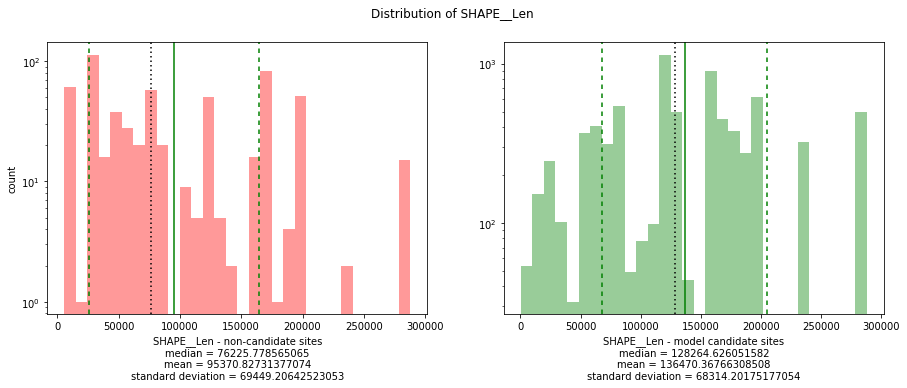

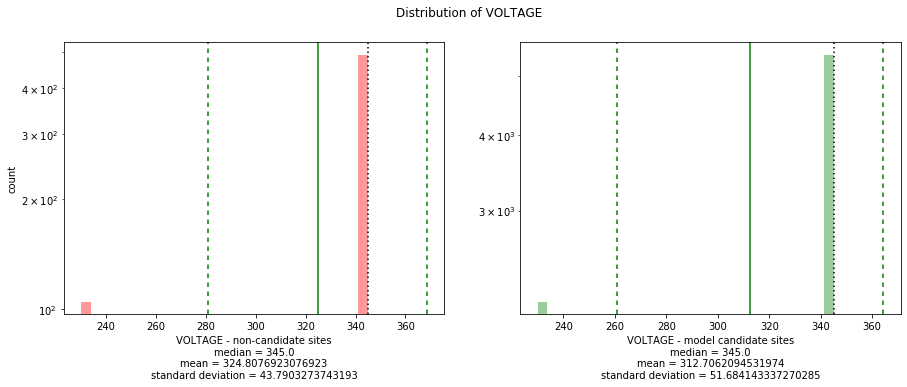

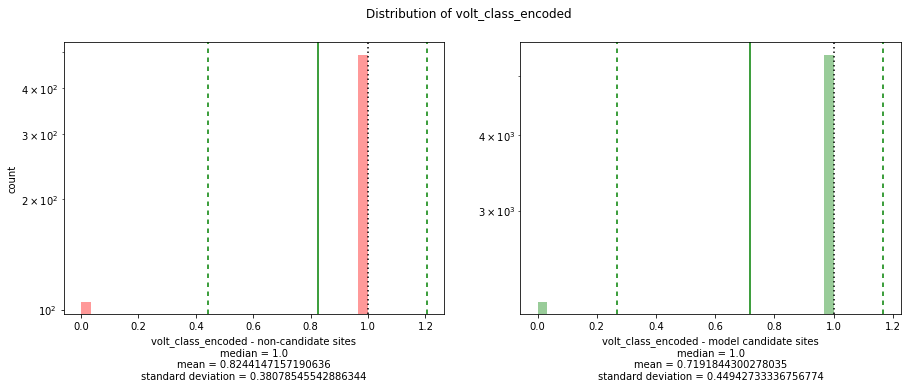

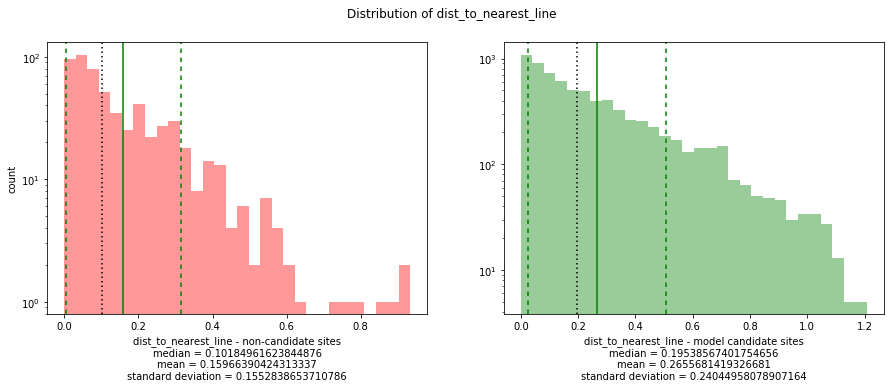

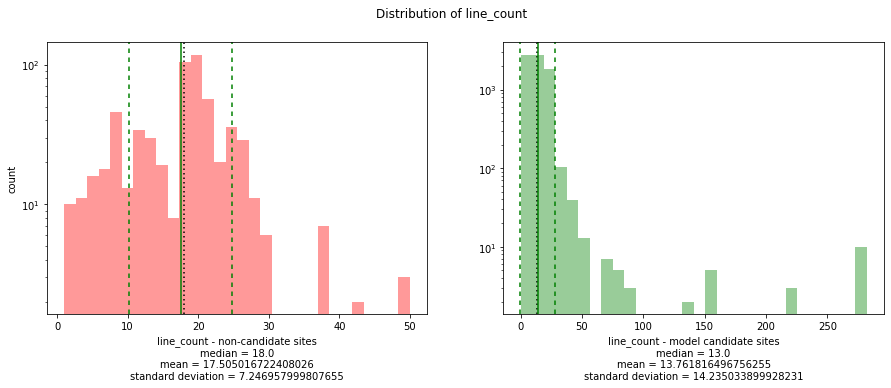

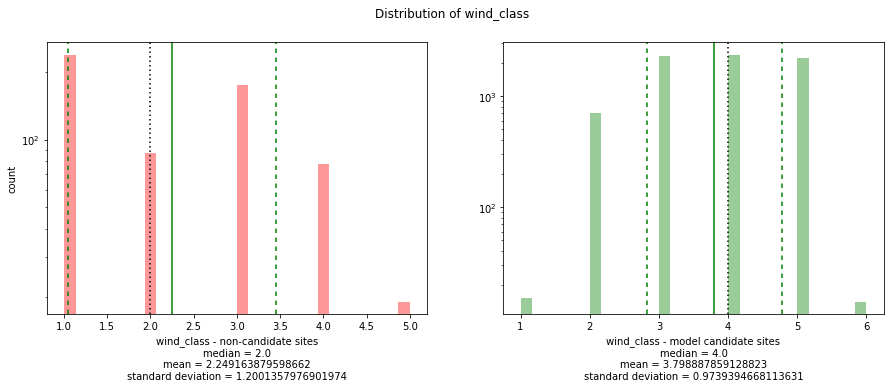

In [269]:
for feature in X_test_out1.drop('geometry',axis='columns').columns:
    if feature == 'build_here':
        continue
    score_distribution(X_test_out1,feature)

### Summary of non-candidate vs. candidate sites

This analysis applies to the summary stats of the features for the state of Kansas. I expect the results to be mostly consistent from state to state.

* __SHAPE\_\_Len: the length of the nearest line to the centroid of the NREL cell__ - candidate sites are closer to much longer lines on average. This is the feature that ranks highest in the random forest model's feature importance.
* __VOLTAGE: voltage of the nearest line__ - there isn't a large difference here. Most of the closest lines are 345-volt lines.
* __volt_class_encoded__ - I created this feature based on the VOLT_CLASS variable in the transmission line dataset. There are only two classes in the Kansas dataset, and the majority of cells are associated with the same class, so this doesn't provide a lot of insight. (However, it still ranks higher in feature importance than, say, wind_class!?)
* __dist_to_nearest_line: distance from the centroid of the NREL cell to the nearest transmission line__ - candidate sites are, on average, farther away from suitable transmission lines than non-candidate sites. Perhaps the extra distance represents more remote sites that lack other structures as well?
* __line_count: the number of transmission lines within a 1-degree latitude/longitude radius of the centroid of the NREL cell__ - candidate sites favor lower transmission line density. I figured this was the case in general. Interestingly though, in the Kansas dataset, there are a few candidate sites that have a high density of nearby transmission lines--over five times the max density of the non-candidate sites.
* __wind_class: NREL wind_class (with no exclusions applied)__ - candidate sites have a significantly higher wind_class on average compared to non-candidate sites. Again, I thought this would have been one of the most significant features to the model, because it represents a lot about a site.

## Conclusions

Considering that most of the features fed to the random forest model were related to the transmission lines close to candidate sites--and considering transmission lines did not figure into AWEA's four main considerations of siting a wind project--I'm pleasantly surprised to see the model performing as well as it does!

I was disappointed to not be able to make better use of the turbine_class feature produced by the unsupervised learning model, but its outputs still led to some useful insights about how the technology has changed over time.

## Future work

* In a production environment, this data would need to be updated periodically. The scripts I wrote are a good start, but they represent a compromise of time vs. available resources for processing. Moving this processing to a cloud environment would open up the possibility of spinning up additional virtual machines to handle the capacity.
* Find more topographic and wind data. NREL's datasets are a decent start, but I feel that some information may be lost in their reduction of so many factors to a single class.
* Incorporate other data, create additional features--such as a feature that negatively weighs a site if it is determined that "shadow flicker" from moving turbines would affect residents in nearby homes.
* I would suggest adding a weight to the density of power lines, to negatively weigh density that represents an urban area, or an area otherwise unsuited to wind turbines...but the random forest model didn't consider line_count very important in its calculations anyway.
* Gather data for other parts of the world, especially offshore locations. 
* Make the output of the supervised learning model more granular? 1 degree of latitude/longitude is a large area to make a single prediction.
* Create an interactive dashboard.
